In [104]:
import sys
import json
import os
from pprint import pprint
from subprocess import call
import subprocess
from subprocess import call, Popen, PIPE, check_output, STDOUT, CalledProcessError
import platform
import time
import shutil
from collections import OrderedDict
import datetime

import matplotlib.pyplot as plt
import pandas as pd

<h1>Killing Leader Node</h1>

In [47]:
# Generate dummy Data
def generate_dummy_data(broker_port, topic, data_source):
        call(f"../deploy/kafka/bin/kafka-console-producer.sh < {data_source} --topic {topic} --broker-list localhost:{broker_port}", shell=True)

<h2>Regular Kafka</h2>

In [82]:
def run():
    data_frame = pd.DataFrame()
    for i in range(0,10):
        start = time.time()
        generate_dummy_data(9092, 'testTopic', 'text.txt')
        end = time.time()
        data_frame.loc[i,'time_taken'] = end - start
        print(".", end=" ")
    return data_frame

...
...
...
...
...
...
...
...
...
...
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')


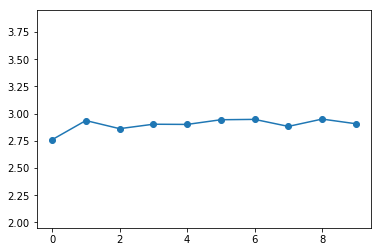

In [83]:
results = run()
print(results.index)
results['index1'] = results.index
plt.scatter(results['index1'], results['time_taken'])
plt.plot(results['index1'], results['time_taken'])
max_val = results['time_taken'].max()
plt.ylim(max_val - 1 ,max_val + 1 )
plt.show()

In [166]:
def kill():
    proc1 = subprocess.Popen(['ps', 'aux'], stdout=subprocess.PIPE)
    proc2 = subprocess.Popen(['grep', '../output/2181_cluster/broker_2181_0.properties'], stdin=proc1.stdout,
                             stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    proc1.stdout.close()
    out, err = proc2.communicate()
    values = out.decode("utf-8").split(" ")
    print(values)
    return values

In [188]:
def run2():
    data_frame = pd.DataFrame()
    port = 9096
    for i in range(0,10):
        if i == 2:
            values = kill()
            call(f"kill -9 5203", shell=True)
            port = 9095
        start = time.time()
        generate_dummy_data(port, 'testTopic', 'text.txt')
        end = time.time()
        data_frame.loc[i,'time_taken'] = end - start
        print(".", end=" ")
    return data_frame

<h3>Producing</h3>

In [184]:
results = run2()

...
...
['nikhile+', '', '7428', '', '0.0', '', '0.0', '1017376', '1124', '?', '', '', '', '', '', '', '', 'S', '', '', '', '20:16', '', '', '0:00', 'grep', '../output/2181_cluster/broker_2181_0.properties\n']
...
...
...
...
...
...
...
...


Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')


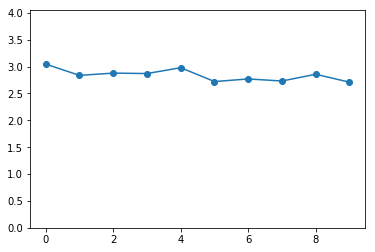

In [179]:
results['index1'] = results.index
plt.scatter(results['index1'], results['time_taken'])
plt.plot(results['index1'], results['time_taken'])
max_val = results['time_taken'].max()
plt.ylim(0 ,max_val + 1 )
plt.show()

<p>Producer seems to be unaffected when killing the leader node.</p>

<h3>Consuming</h3>

In [192]:
def run_consumer():
    consumer = KafkaConsumer(bootstrap_servers='localhost:9094',
                                 auto_offset_reset='earliest',
                                 consumer_timeout_ms=1000)
    consumer.subscribe(['testTopic'])
    data_frame = pd.DataFrame()
    counter = 0
    for message in consumer:
        if counter > 9:
            break
        start = time.time()
        print(f"Recieved Message: {message.value}")
        end = time.time()
        data_frame.loc[i,'time_taken'] = end - start
        counter += 1
        print(".", end=" ")
    return data_frame